In [14]:
!nvidia-smi

Tue Oct 14 14:59:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

## Install YOLO11 via Ultralytics

In [15]:
%pip install "ultralytics<=8.3.40" supervision roboflow
# prevent ultralytics from tracking your activity
!yolo settings sync=False
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.3/112.6 GB disk)


## Fine-tune YOLO11 on custom dataset

**NOTE:** When training YOLOv11, make sure your data is located in `datasets`. If you'd like to change the default location of the data you want to use for fine-tuning, you can do so through Ultralytics' `settings.json`. In this tutorial, we will use one of the [datasets](https://universe.roboflow.com/liangdianzhong/-qvdww) available on [Roboflow Universe](https://universe.roboflow.com/). When downloading, make sure to select the `yolov11` export format.

In [16]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

from google.colab import userdata
from roboflow import Roboflow

rf = Roboflow(api_key="ukC52GkAEcfs2ngKxaXK")
project = rf.workspace("echs-bmmgs").project("bone-fracture-detection-khatl-04j6x")
version = project.version(1)
dataset = version.download("yolov11")

mkdir: cannot create directory ‘{HOME}/datasets’: No such file or directory
[Errno 2] No such file or directory: '{HOME}/datasets'
/content
loading Roboflow workspace...
loading Roboflow project...


## Custom Training

In [21]:
import os

HOME = os.path.expanduser("~")
print(HOME)

/root


In [22]:
%cd {HOME}

!yolo task=detect mode=train model=yolo11s.pt data={dataset.location}/data.yaml epochs=20 imgsz=640 plots=True

/root
100% 18.4M/18.4M [00:00<00:00, 176MB/s]
New https://pypi.org/project/ultralytics/8.3.214 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=/content/Bone-Fracture-Detection-1/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, class

**NOTE:** The results of the completed training are saved in `{HOME}/runs/detect/train/`. Let's examine them.

In [23]:
!ls {HOME}/runs/detect/train/

args.yaml					     train_batch1240.jpg
confusion_matrix_normalized.png			     train_batch1241.jpg
confusion_matrix.png				     train_batch1242.jpg
events.out.tfevents.1760455479.5e618a221476.18981.0  train_batch1.jpg
F1_curve.png					     train_batch2.jpg
labels_correlogram.jpg				     val_batch0_labels.jpg
labels.jpg					     val_batch0_pred.jpg
P_curve.png					     val_batch1_labels.jpg
PR_curve.png					     val_batch1_pred.jpg
R_curve.png					     val_batch2_labels.jpg
results.csv					     val_batch2_pred.jpg
results.png					     weights
train_batch0.jpg


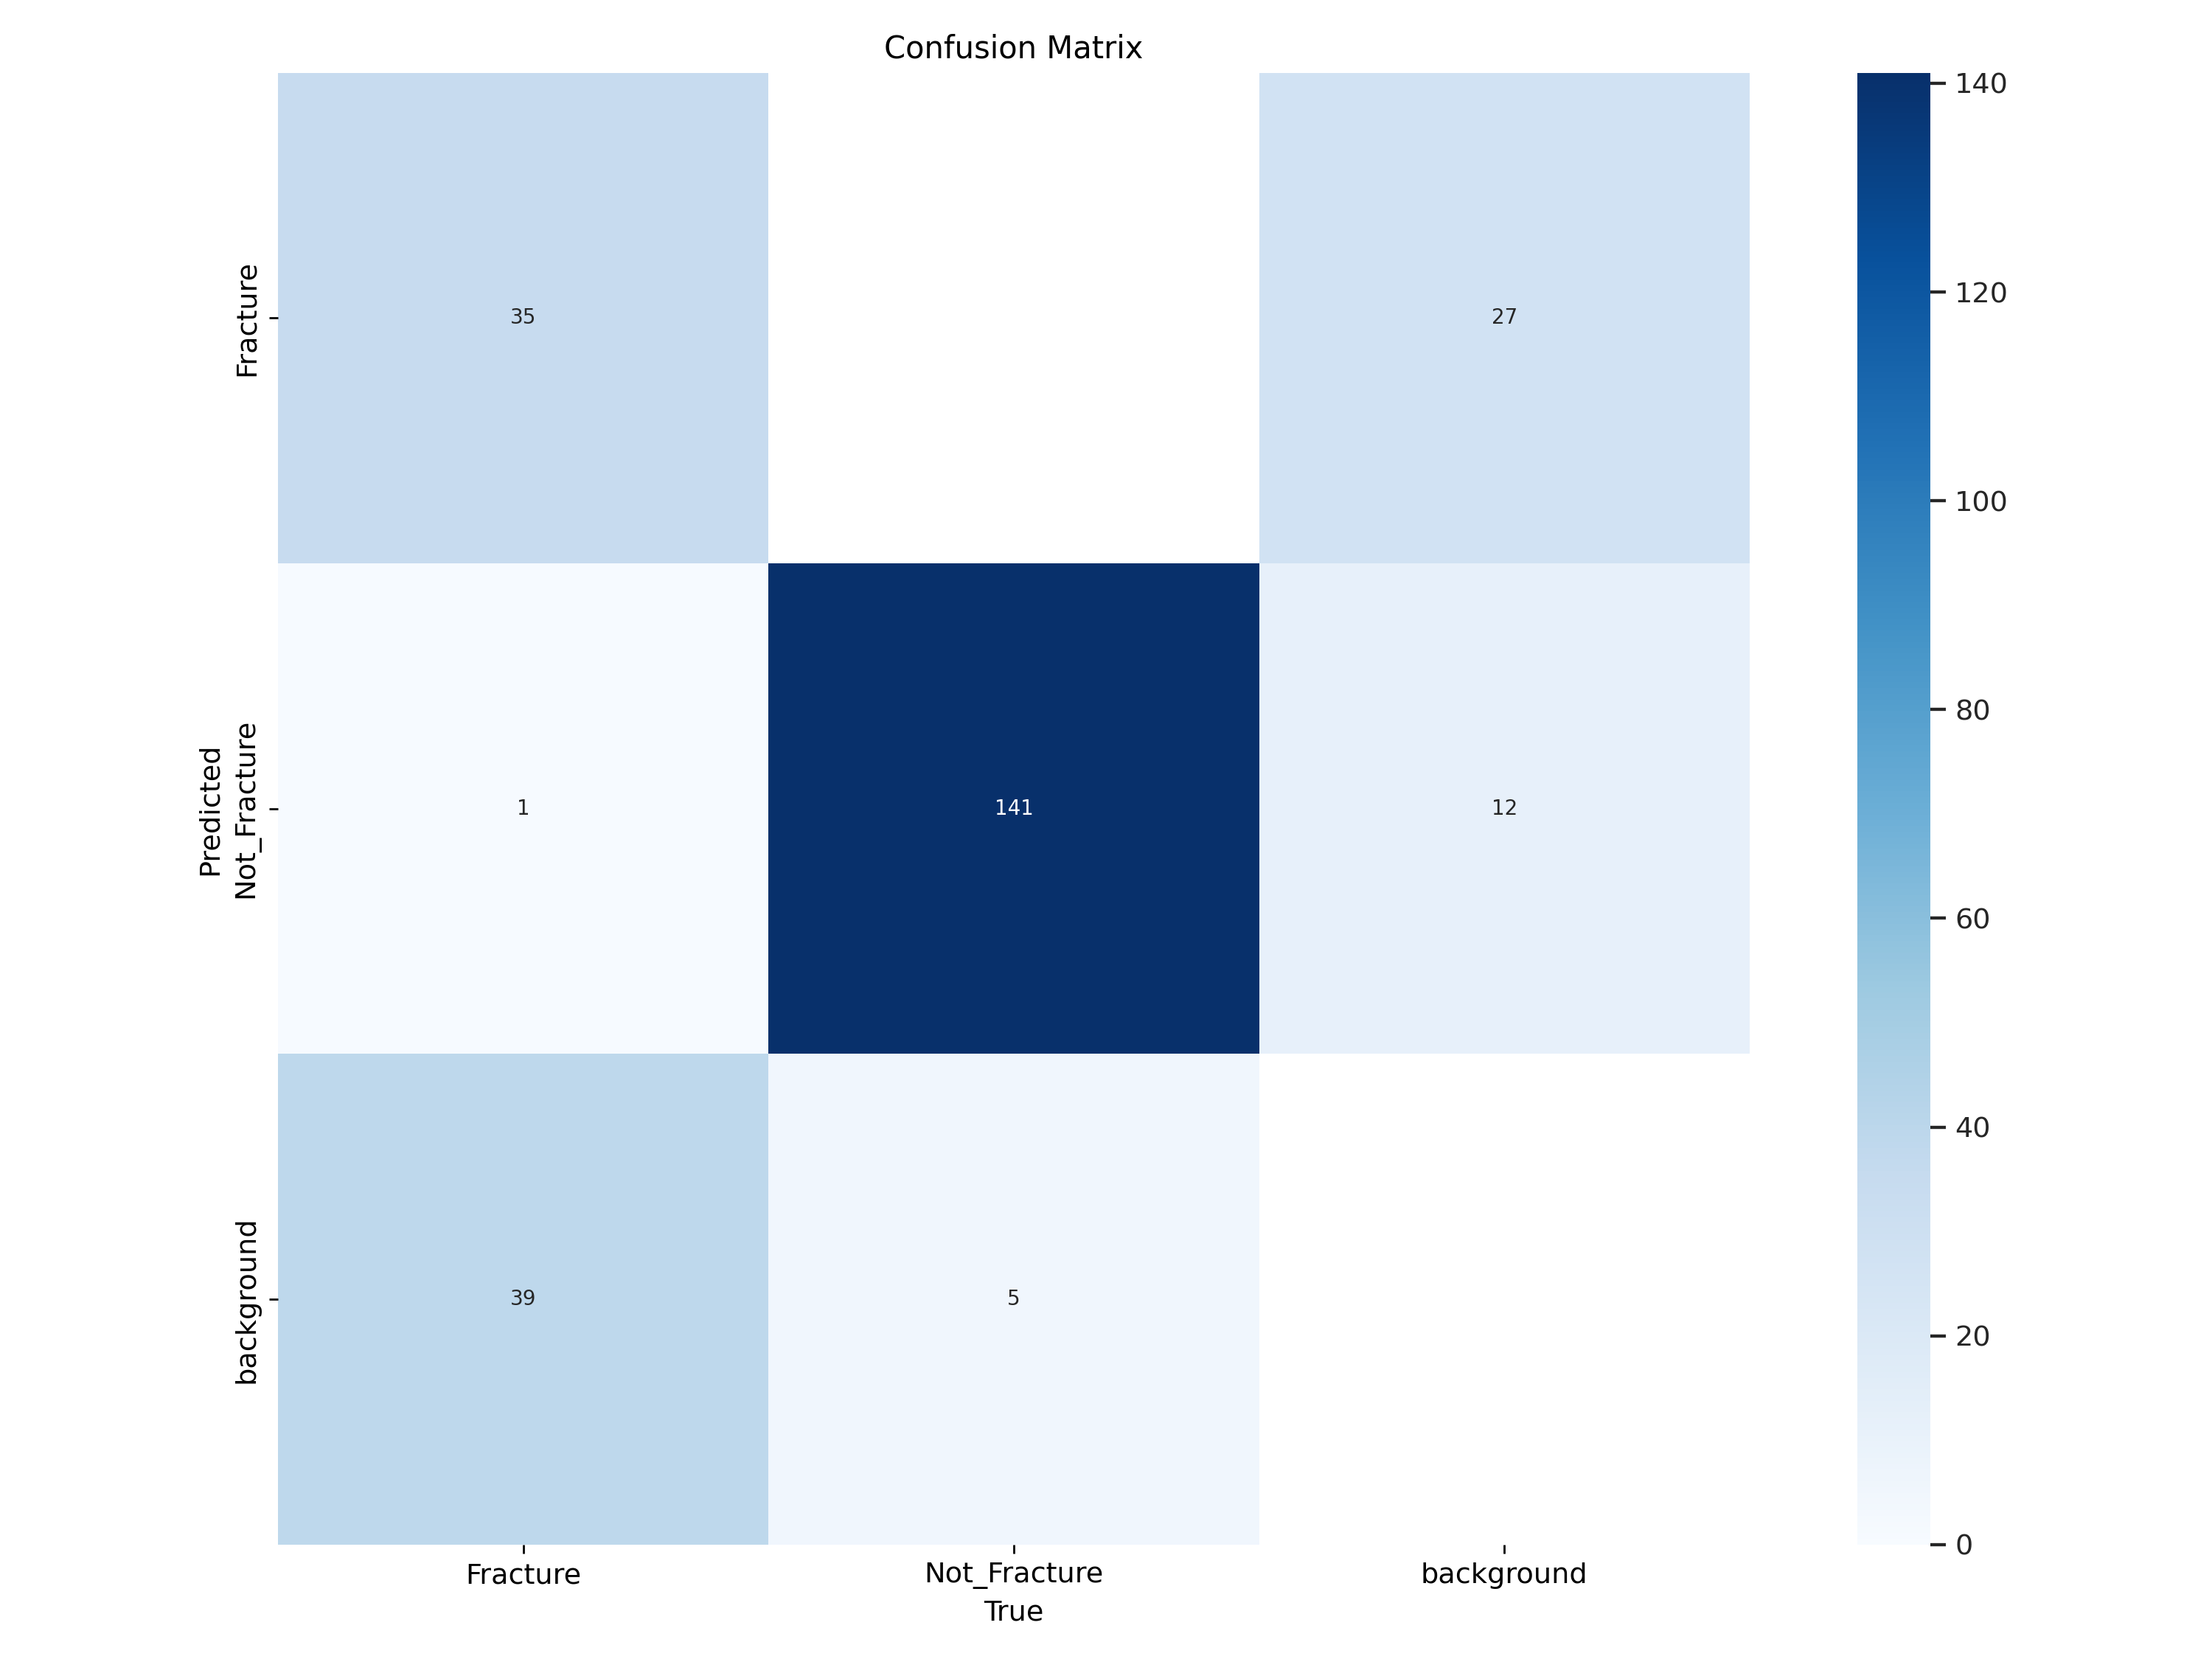

In [24]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

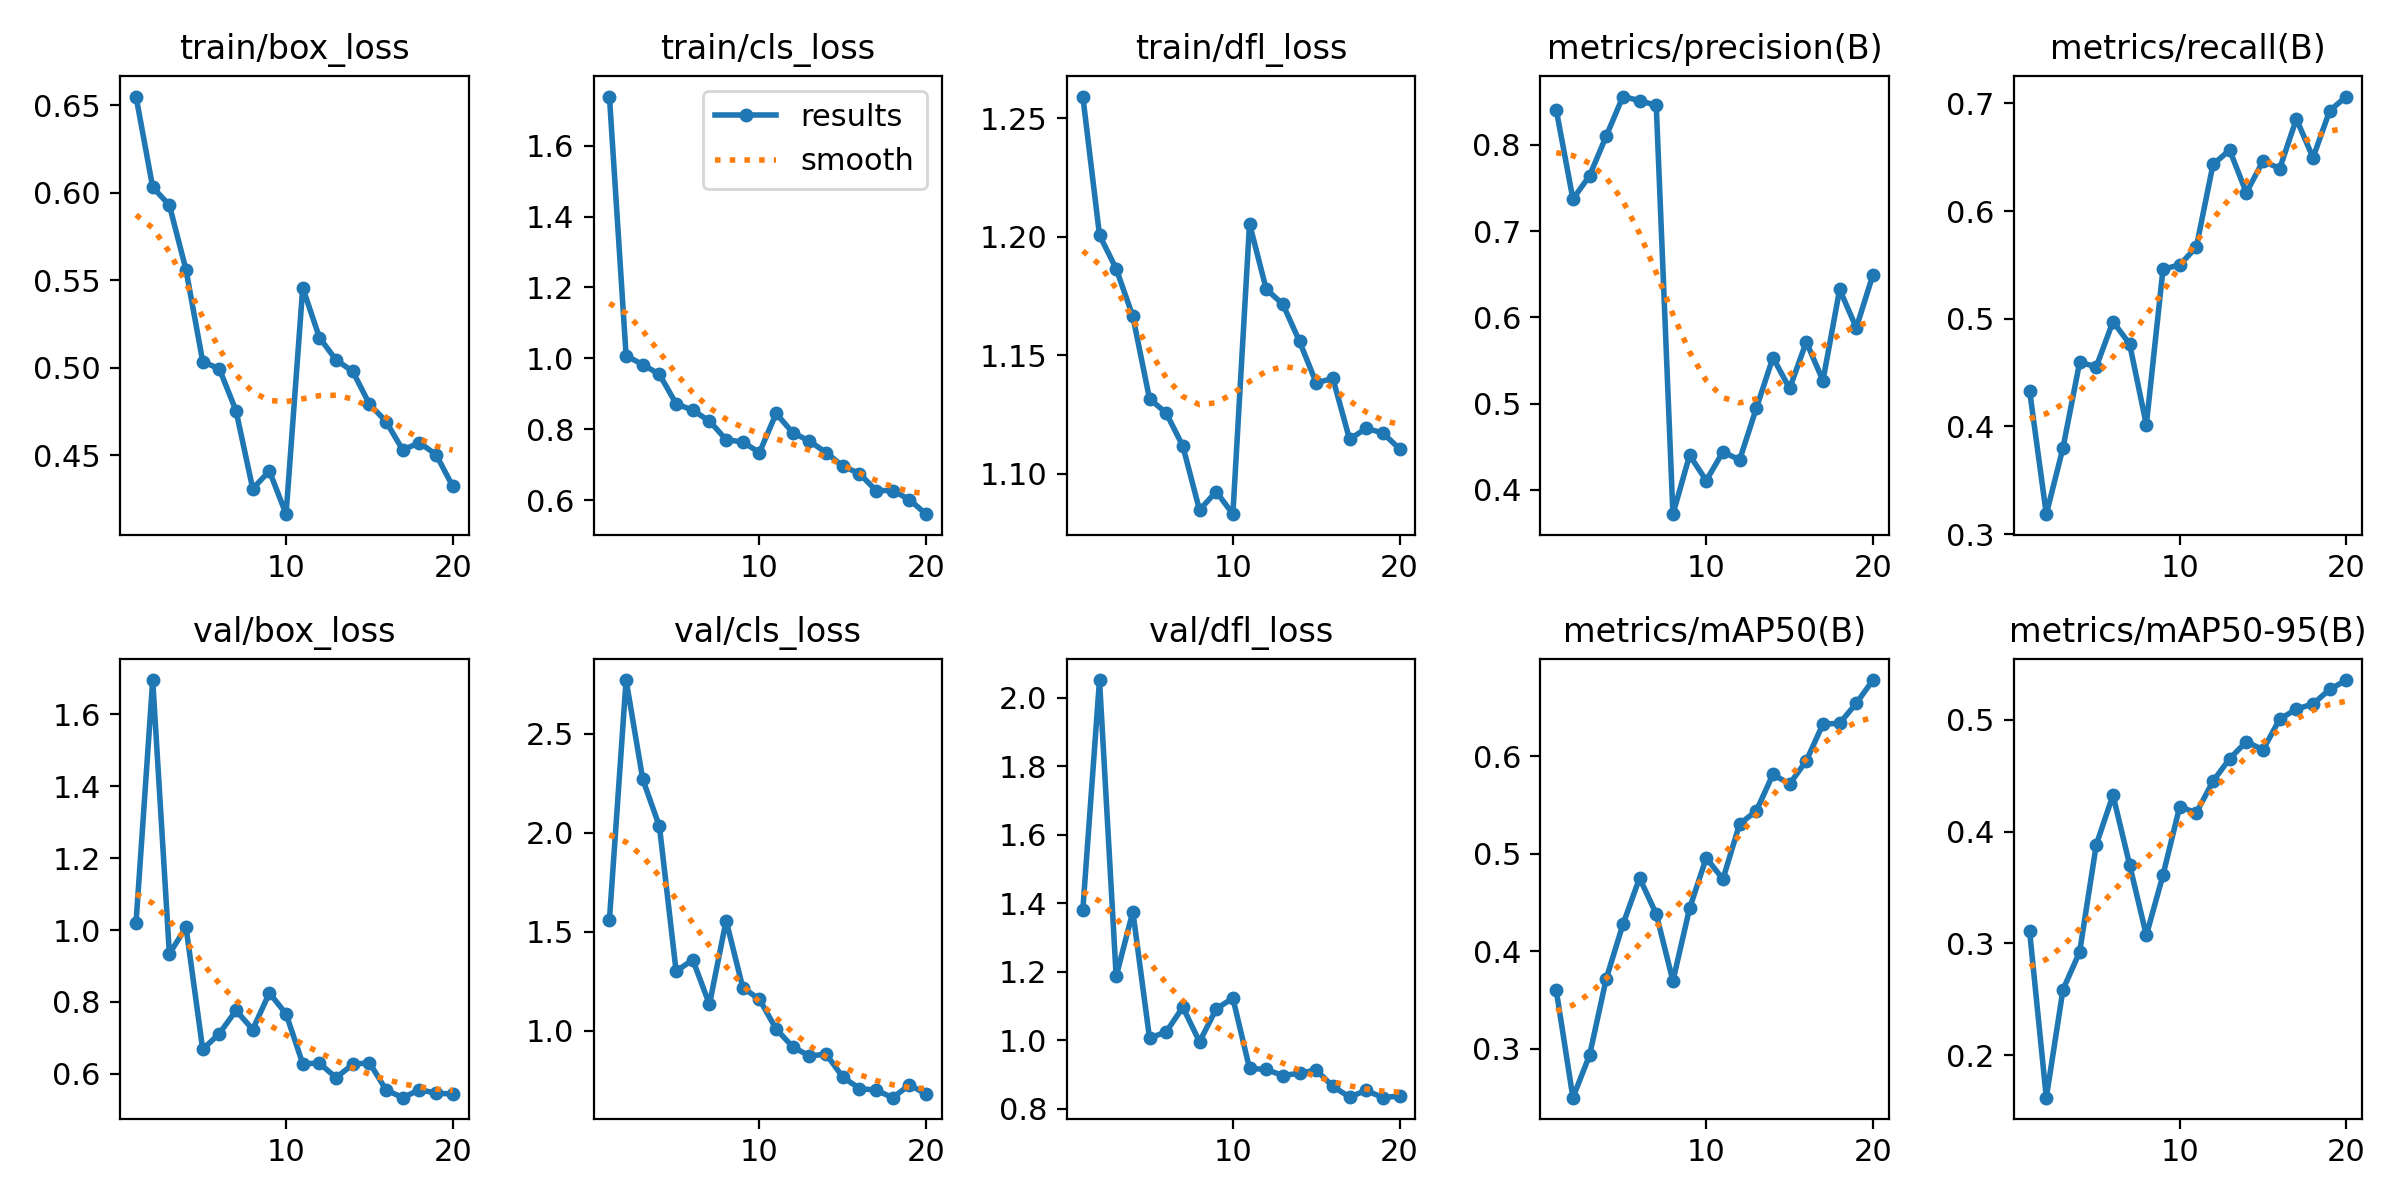

In [25]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

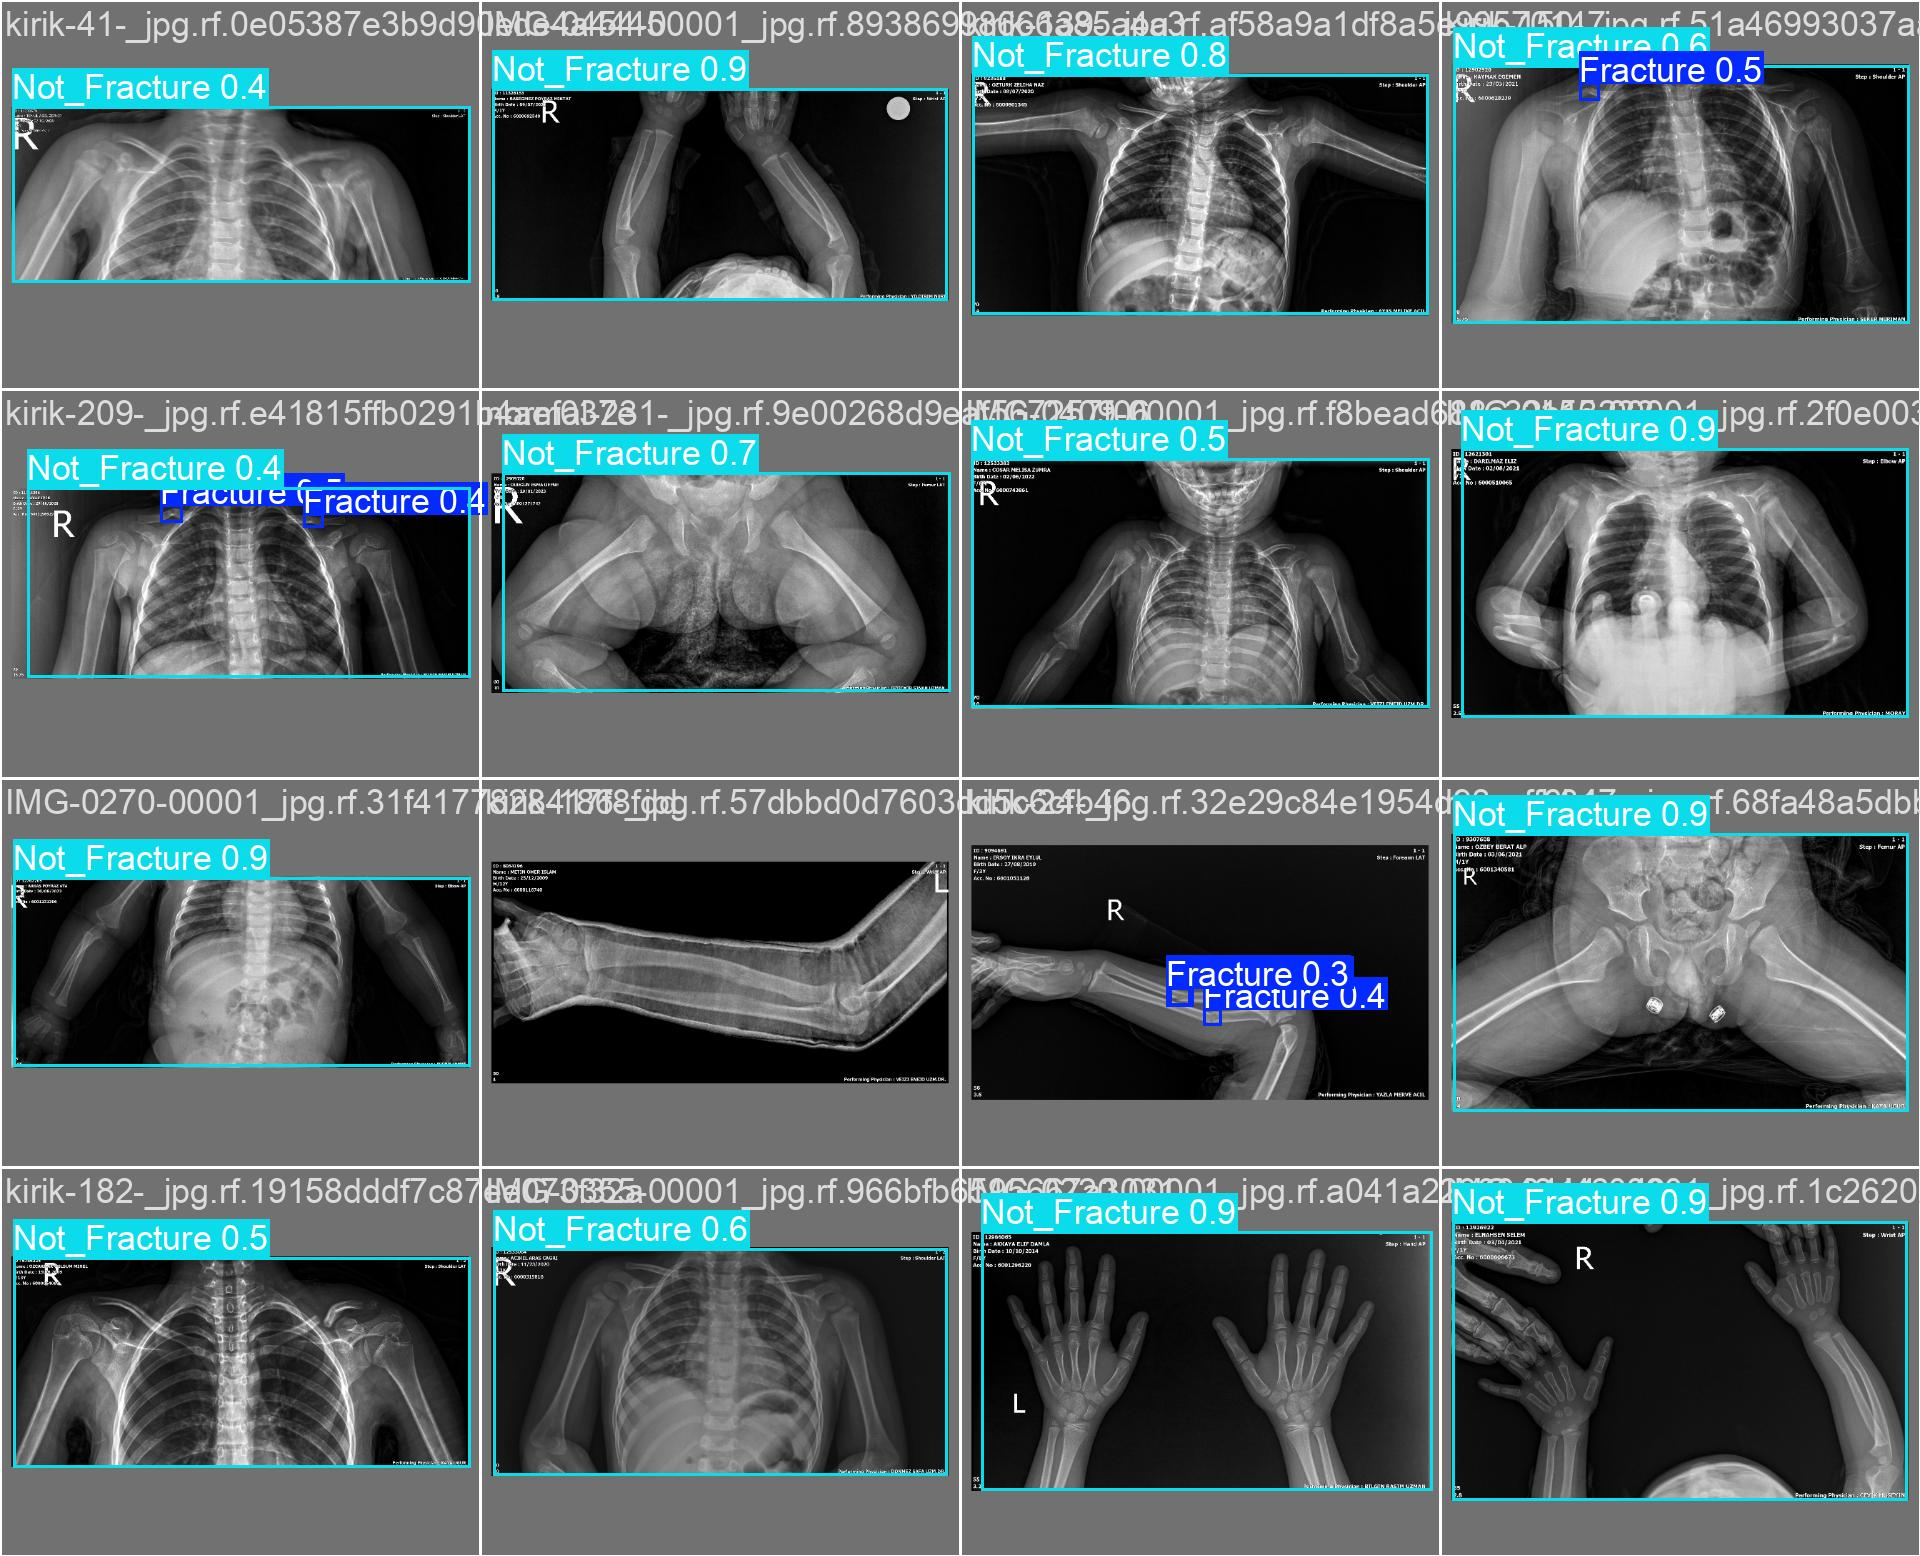

In [26]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate fine-tuned model

In [27]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs
val: Scanning /content/Bone-Fracture-Detection-1/valid/labels.cache... 209 images, 0 backgrounds, 0 corrupt: 100% 209/209 [00:00<?, ?it/s]
val: WARNING ⚠️ /content/Bone-Fracture-Detection-1/valid/images/normal-59-_jpg.rf.562837162ab649cdb77be50df327b4d5.jpg: 1 duplicate labels removed
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 14/14 [00:04<00:00,  3.10it/s]
                   all        209        221      0.652      0.706      0.681      0.534
              Fracture         63         75      0.492      0.439      0.396      0.139
          Not_Fracture        146        146      0.811      0.973      0.966       0.93
Speed: 1.4ms preprocess, 10.4ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytic

## Inference with custom model

In [28]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.40 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 238 layers, 9,413,574 parameters, 0 gradients, 21.3 GFLOPs

image 1/104 /content/Bone-Fracture-Detection-1/test/images/IMG-0006-00001_jpg.rf.b8e87c3de36c9766245e5e19c5c50e89.jpg: 640x480 1 Not_Fracture, 80.2ms
image 2/104 /content/Bone-Fracture-Detection-1/test/images/IMG-0010-00001_jpg.rf.7f9c2ee206417618af871cca2a8c9fdc.jpg: 544x640 1 Not_Fracture, 53.8ms
image 3/104 /content/Bone-Fracture-Detection-1/test/images/IMG-0014-00001_jpg.rf.233e8e678b704d605efe508b5149af98.jpg: 640x480 1 Fracture, 1 Not_Fracture, 15.1ms
image 4/104 /content/Bone-Fracture-Detection-1/test/images/IMG-0015-00001_jpg.rf.8c0fd4a9cc566b1878f6bfb5e45eabfc.jpg: 576x640 1 Not_Fracture, 62.3ms
image 5/104 /content/Bone-Fracture-Detection-1/test/images/IMG-0020-00001_jpg.rf.3606f7675d73d5ebba38b789718aebe2.jpg: 640x352 1 Not_Fracture, 49.9ms
image 6/104 /content/Bone-Fracture-Detection-1/test/images/IMG-0022-000

**NOTE:** Let's take a look at few results.

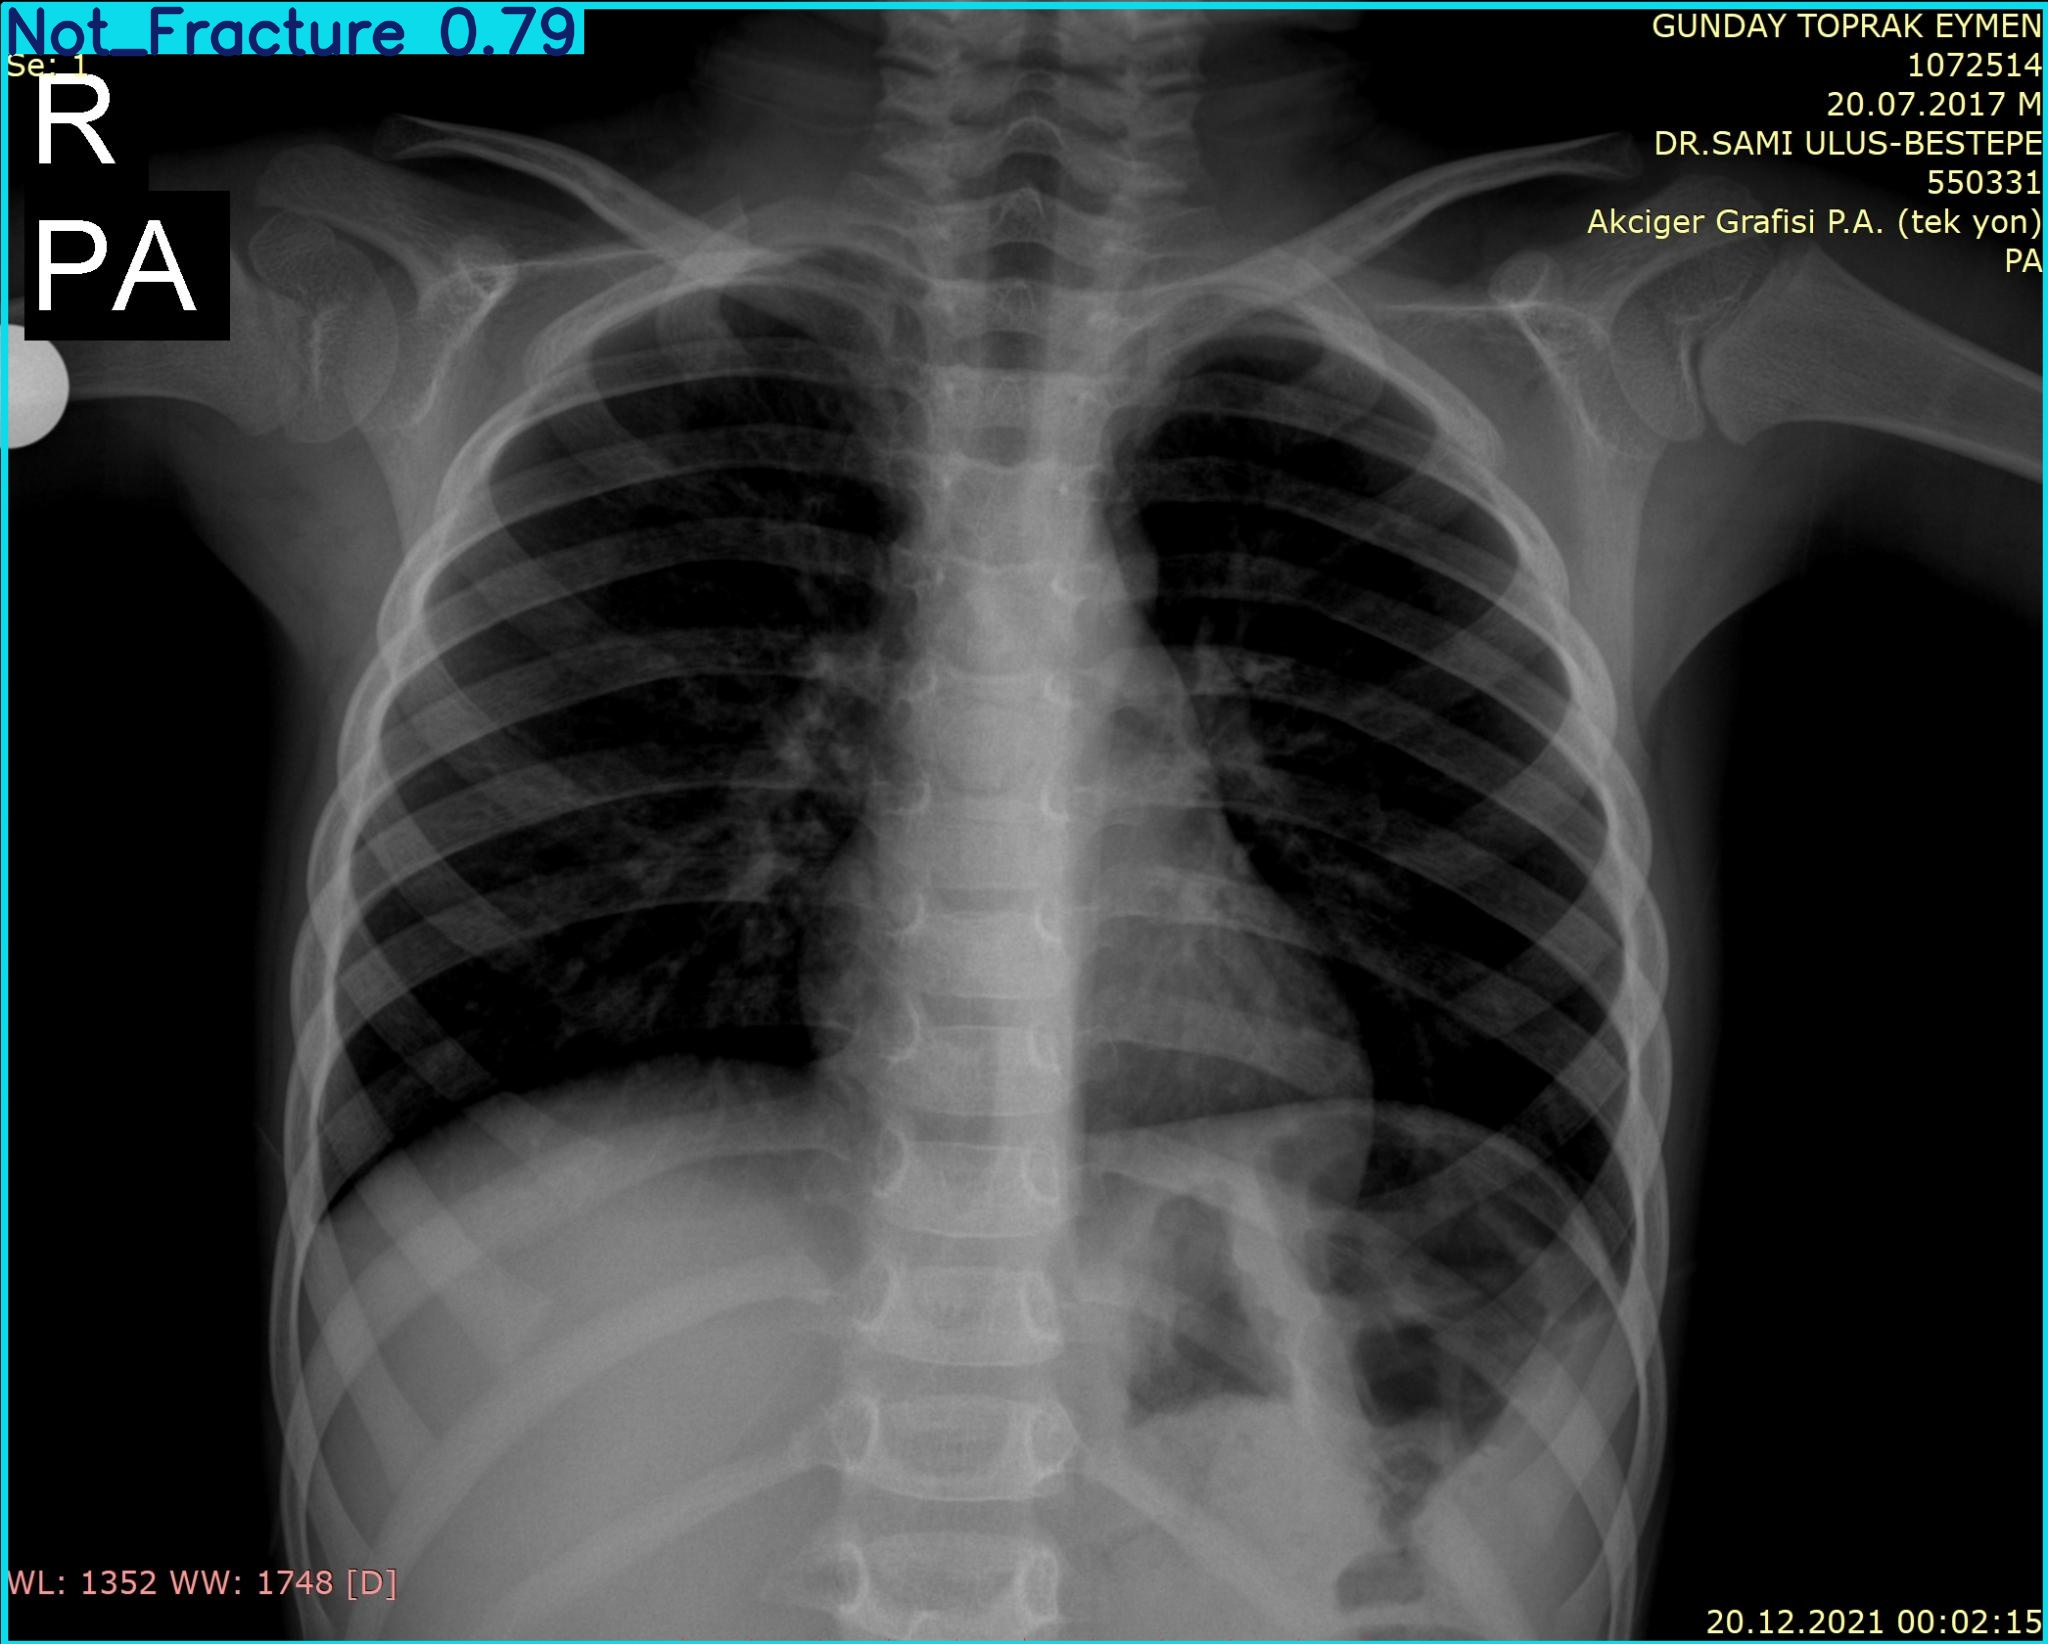

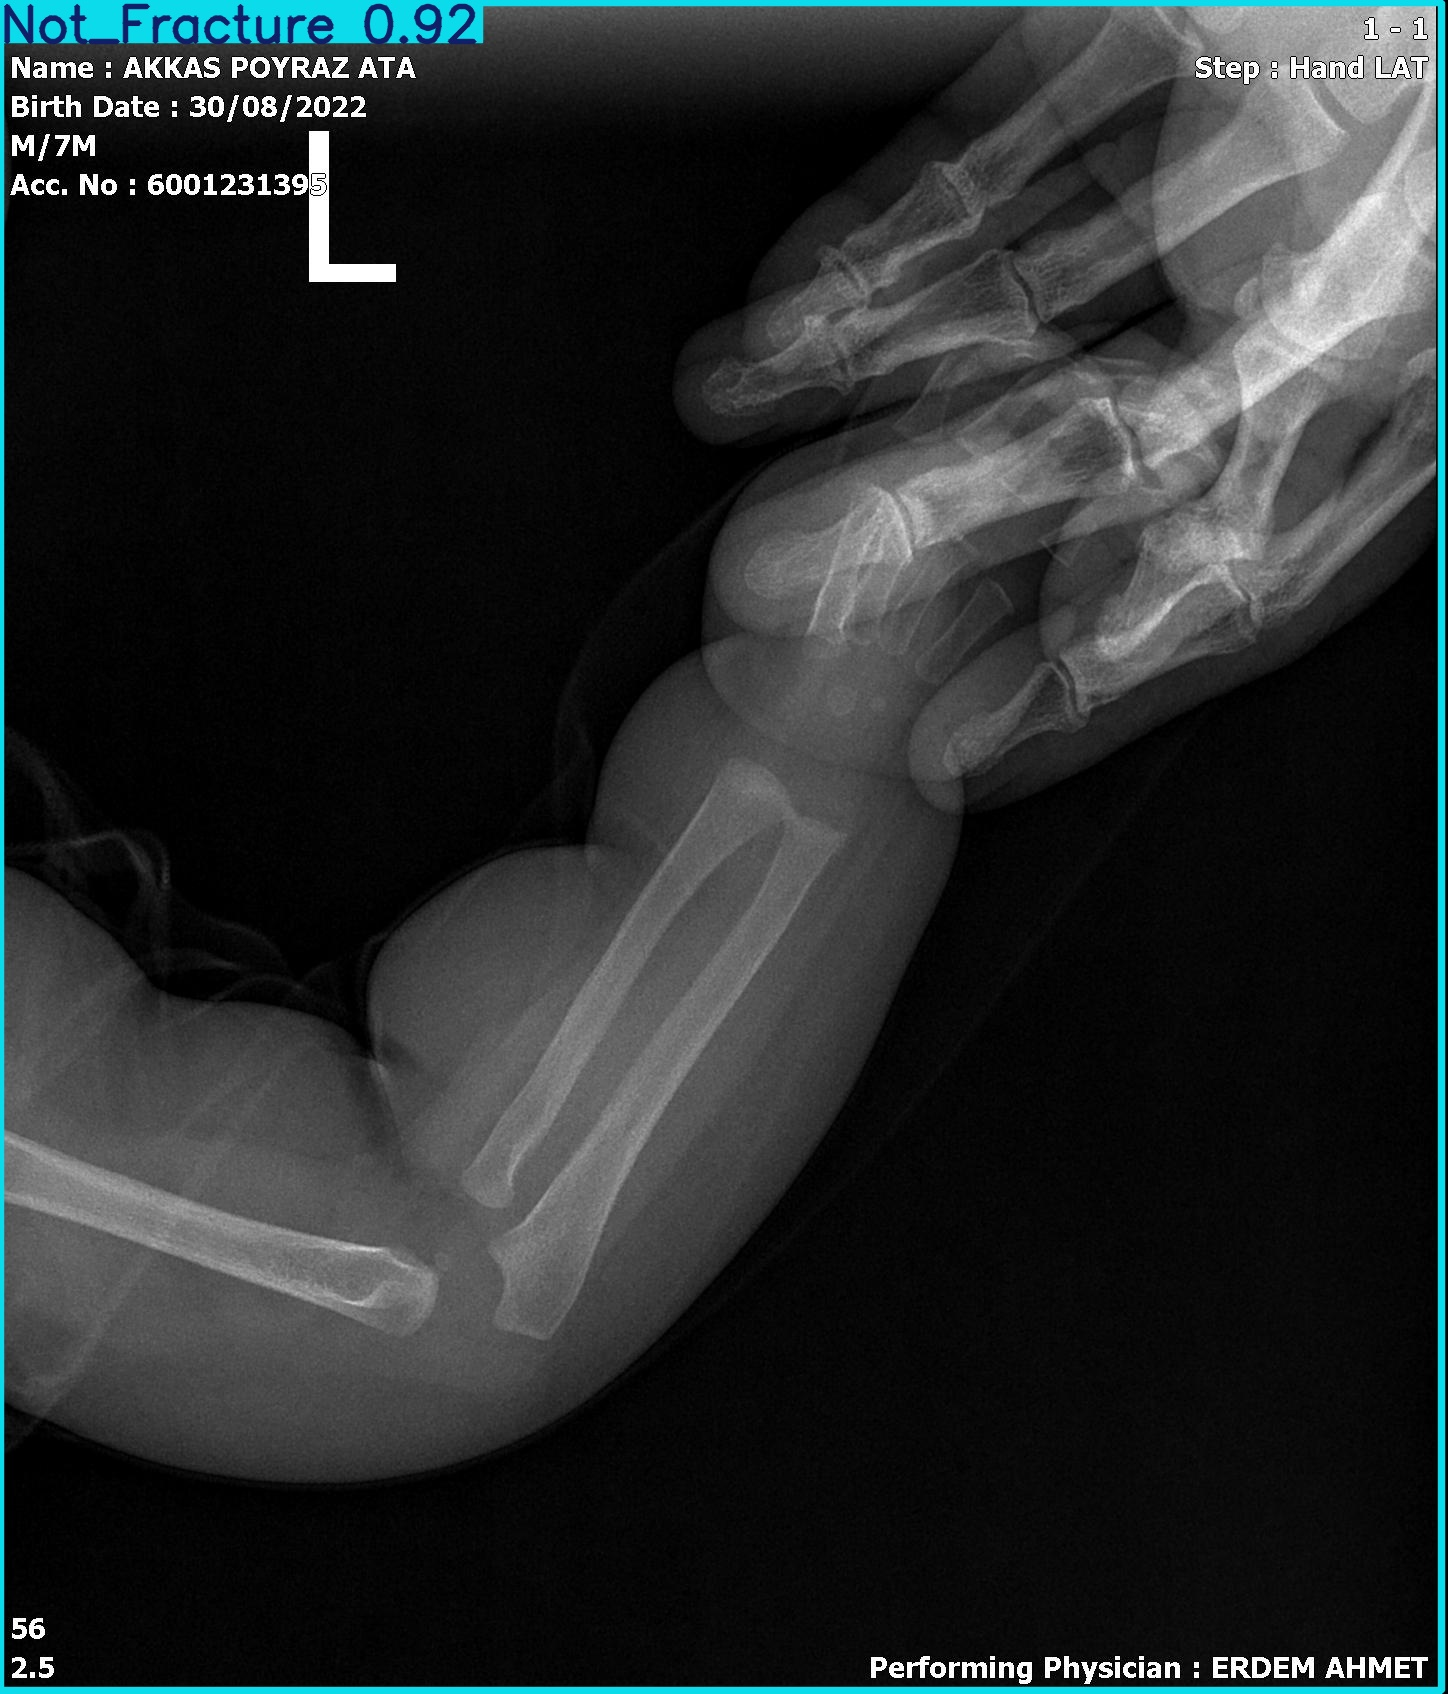

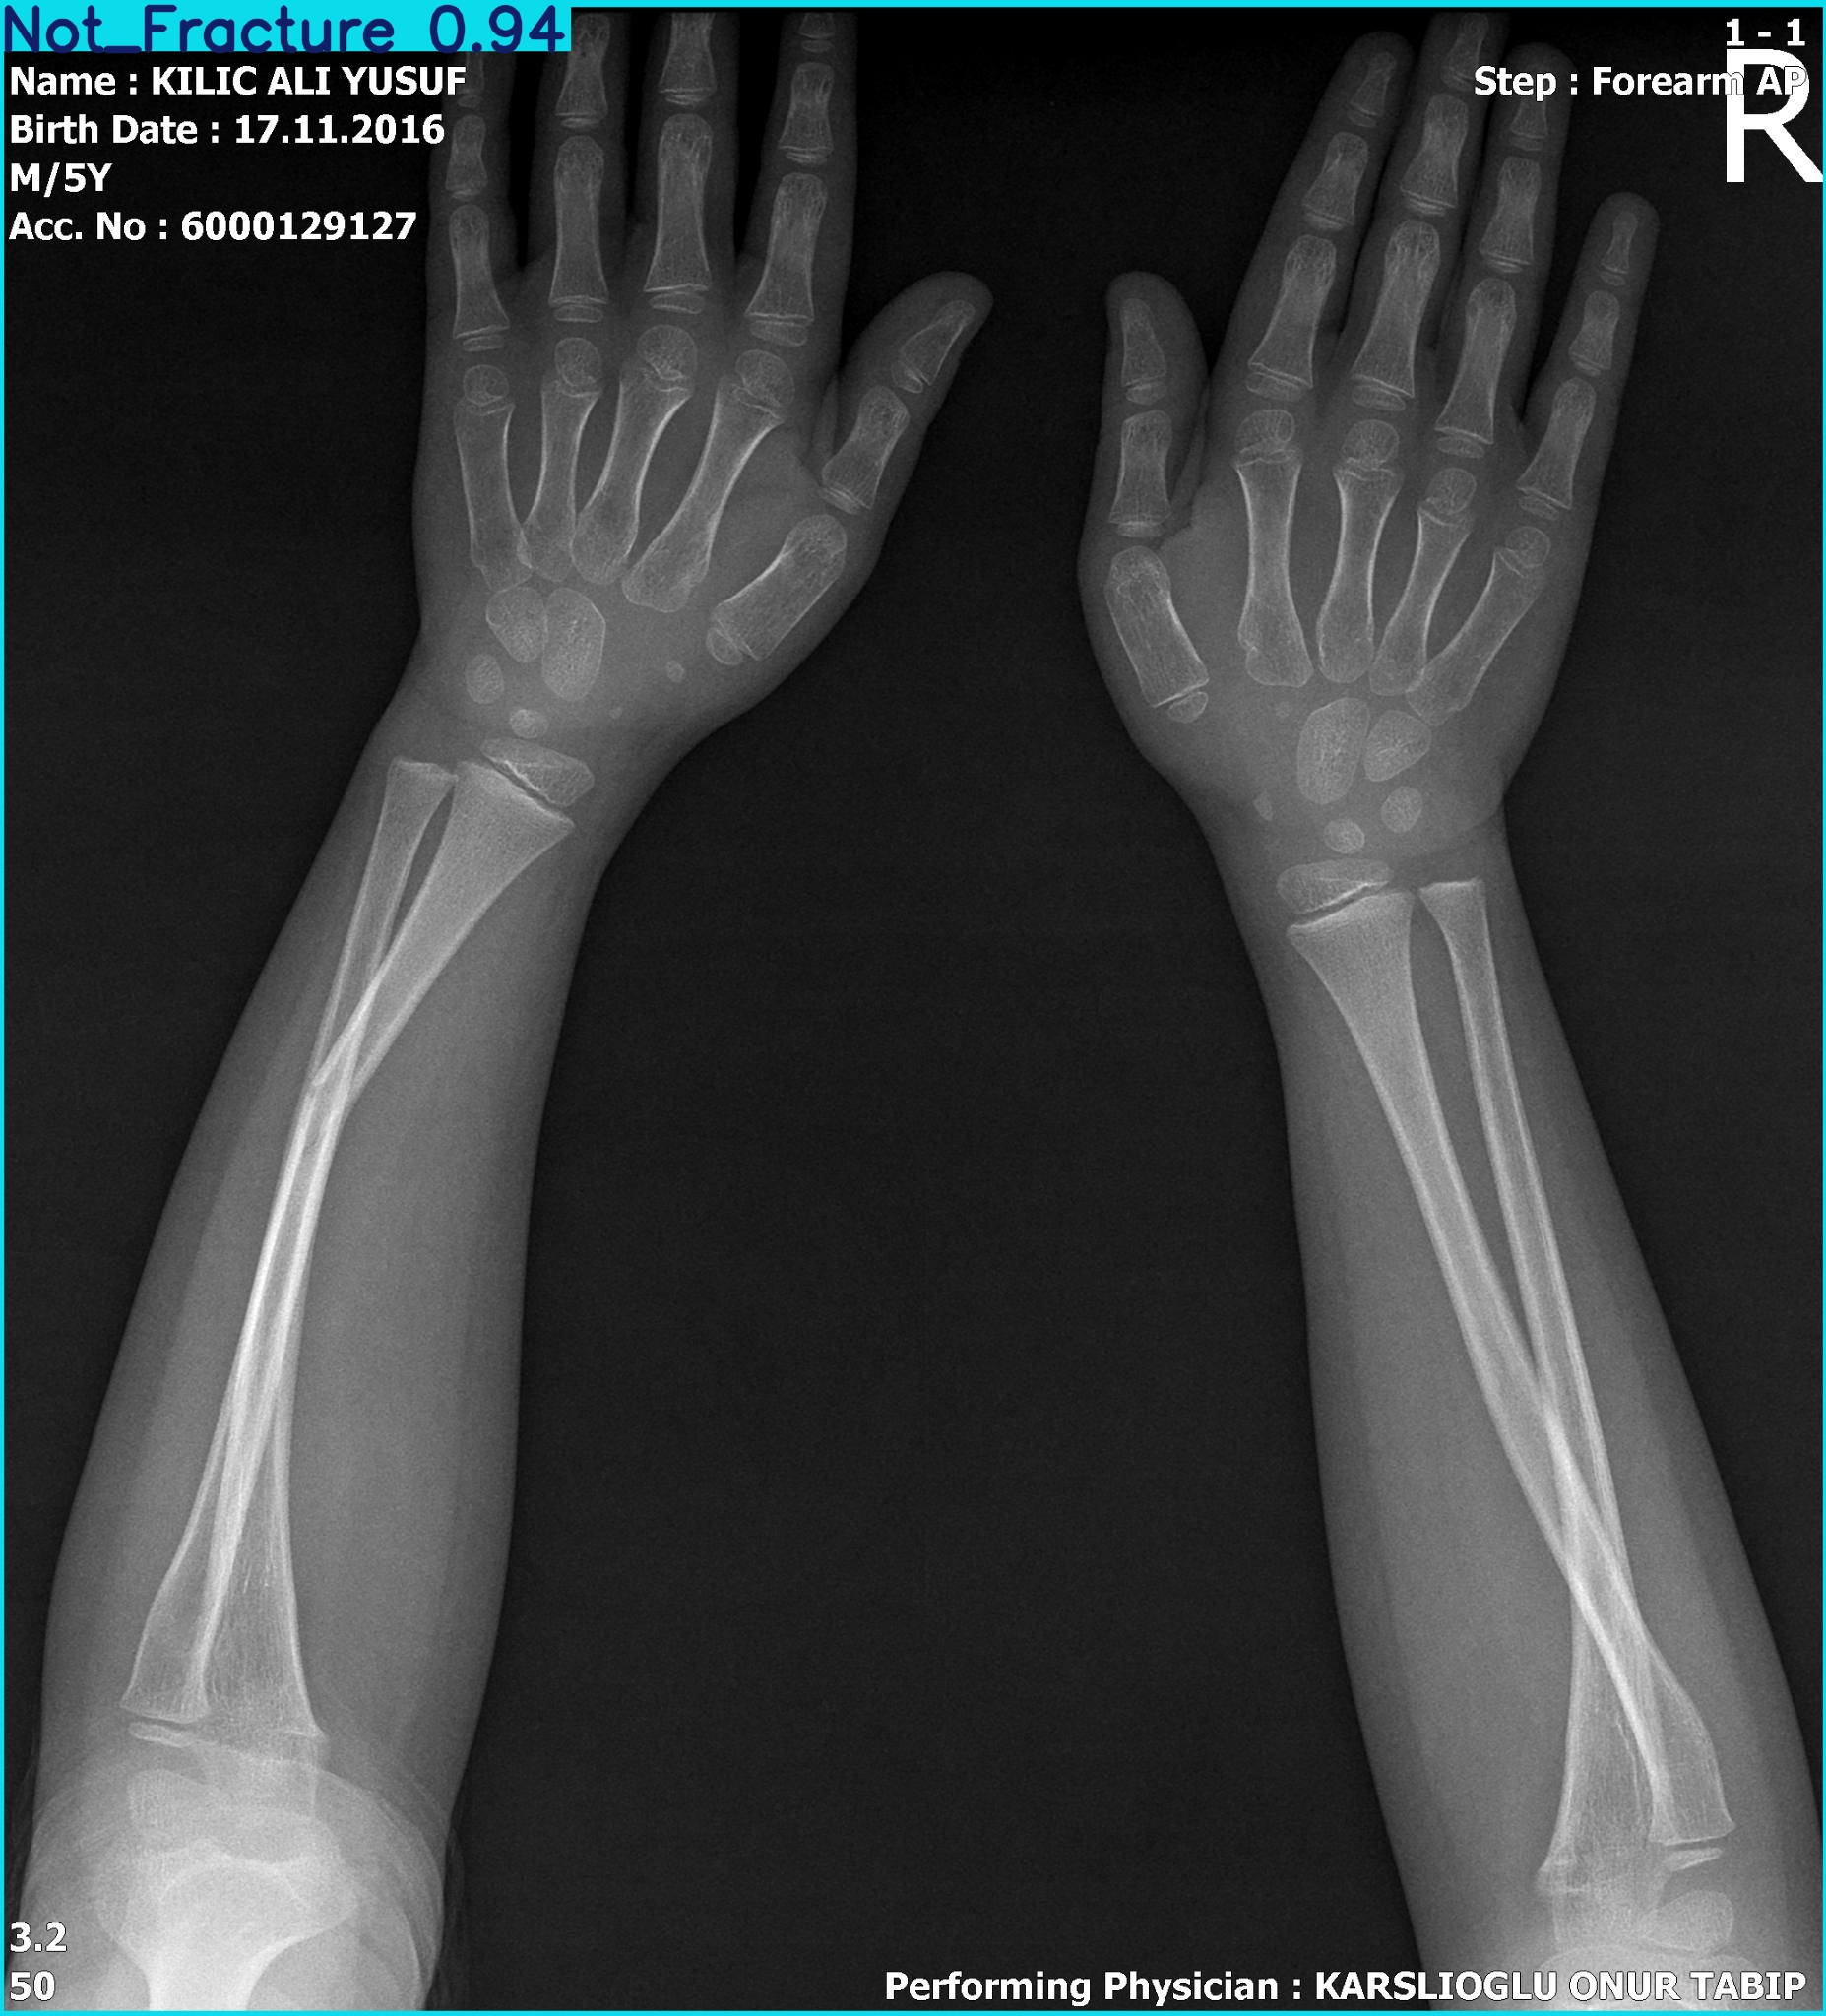

In [29]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob(f'{HOME}/runs/detect/predict*/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:3]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Deploy model on Roboflow

Once you have finished training your YOLOv11 model, you’ll have a set of trained weights ready for use. These weights will be in the `/runs/detect/train/weights/best.pt` folder of your project. You can upload your model weights to Roboflow Deploy to use your trained weights on our infinitely scalable infrastructure.

The `.deploy()` function in the [Roboflow pip package](https://docs.roboflow.com/python) now supports uploading YOLOv11 weights.

In [30]:
project.version(dataset.version).deploy(model_type="yolov11", model_path=f"{HOME}/runs/detect/train/")

An error occured when getting the model upload URL: This version already has a trained model. Please generate and train a new version in order to upload model to Roboflow.


In [ ]:
!pip install inference

In [ ]:
import os, random, cv2
import supervision as sv
import IPython
import inference

model_id = project.id.split("/")[1] + "/" + dataset.version
model = inference.get_model(model_id, userdata.get('ROBOFLOW_API_KEY'))

# Location of test set images
test_set_loc = dataset.location + "/test/images/"
test_images = os.listdir(test_set_loc)

# Run inference on 4 random test images, or fewer if fewer images are available
for img_name in random.sample(test_images, min(4, len(test_images))):
    print("Running inference on " + img_name)

    # Load image
    image = cv2.imread(os.path.join(test_set_loc, img_name))

    # Perform inference
    results = model.infer(image, confidence=0.4, overlap=30)[0]
    detections = sv.Detections.from_inference(results)

    # Annotate boxes and labels
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    annotated_image = box_annotator.annotate(scene=image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Display annotated image
    _, ret = cv2.imencode('.jpg', annotated_image)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)
